In [1]:
import os
import zipfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from transformers import BertTokenizer, TFAlbertForTokenClassification

2022-06-17 16:36:54.179750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_root = '../../data/'
local_zip = data_root + 'msra.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('../../data/')
zip_ref.close()

In [3]:
def get_data_path(data_dir=data_root + 'msra/', type='train'):
    if type in ['train', 'val', 'test']:
        sentences_path = os.path.join(data_dir, type, 'sentences.txt')
        tags_path = os.path.join(data_dir, type, 'tags.txt')
        return sentences_path, tags_path
    else:
        raise ValueError("data type not in ['train', 'val', 'test']")


In [4]:
max_len = 128
batch_size = 32
model_name = 'clue/albert_chinese_tiny'
saved_model = 'tr_ner_albert'

In [24]:
class Label_Tokenizer(object):
    def __init__(self, labels, max_length):
        super().__init__()
        self.size = len(labels)
        label2id = {k: v for v, k in enumerate(labels)}
        id2label = {v: k for v, k in enumerate(labels)}
        self.label2id = label2id
        self.id2label = id2label
        self.max_length = max_length

    def tokenize(self, labels):
        tokens = [self._tokenize(label) for label in labels]
        return tokens

    def _tokenize(self, label):
        label = label.decode('utf-8') if hasattr(label, 'decode') else label
        labels = [le for le in label.strip().split(' ')]
        special_token = self.encode(['O'])[0]

        tokens = self.encode(labels)
        tokens = tokens[:self.max_length - 2]
        tokens = [special_token] + tokens + [special_token]
        # Add padded TAG tokens
        padding_len = self.max_length - len(tokens)
        tokens = tokens + ([special_token] * padding_len)
        return tokens

    def encode(self, labels):
        return [self.label2id[label] for label in labels]

    def decode(self, ids):
        return [self.label2id[id] for id in ids]


In [25]:
labels = ['O', 'B-ORG', 'I-PER', 'B-PER', 'I-LOC', 'I-ORG', 'B-LOC']
label_tokenizer = Label_Tokenizer(labels, max_length=max_len)
labels_num = label_tokenizer.size

In [7]:
class Sentence_Tokenizer(object):
    def __init__(self, model_name, max_length=128, padded_token=True):
        super().__init__()
        self.max_length = max_length
        self.padded_token = padded_token
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
    
    def bert_pack_inputs(self, sentences):
        input_ids = []
        attention_masks = []
        token_type_ids = []
        for sentence in sentences:
            tokens = self.tokenize(sentence, self.padded_token)
            input_ids.append(tokens['input_ids'])
            attention_masks.append(tokens['attention_mask'])
            token_type_ids.append(tokens['token_type_ids'])
        return [tf.constant(input_ids), tf.constant(token_type_ids), tf.constant(attention_masks)]
    
    def tokenize(self, sentence, padded_token=True):
        padiding = 'max_length' if padded_token else True
        tokens = self.tokenizer(text=sentence.strip(), max_length=self.max_length, truncation=True, padding=padiding, add_special_tokens=True)
        return tokens
    
    def decode(self, tokens):
        words = self.tokenizer.decode(tokens)
        return words

In [8]:
tokenizer = Sentence_Tokenizer(model_name, max_length=max_len)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [26]:
sentences_file, tags_file = get_data_path()
sentences = tf.data.TextLineDataset(sentences_file).take(16000)
sentences = [sentence.decode('utf-8') for sentence in sentences.as_numpy_iterator()]
x_train = tokenizer.bert_pack_inputs(sentences)

labels = tf.data.TextLineDataset(tags_file).take(16000)
labels = [label.decode('utf-8') for label in labels.as_numpy_iterator()]
y_train = label_tokenizer.tokenize(labels)
y_train = tf.constant(y_train)
print(len(y_train))

16000


In [27]:
sentences_file, tags_file = get_data_path(type='val')
sentences = tf.data.TextLineDataset(sentences_file).take(160)
sentences = [sentence.decode('utf-8') for sentence in sentences.as_numpy_iterator()]
x_val = tokenizer.bert_pack_inputs(sentences)

labels = tf.data.TextLineDataset(tags_file).take(160)
labels = [label.decode('utf-8') for label in labels.as_numpy_iterator()]
y_val = label_tokenizer.tokenize(labels)
y_val = tf.constant(y_val)
print(len(y_val))

160


In [28]:
sentences_file, tags_file = get_data_path(type='test')
sentences = tf.data.TextLineDataset(sentences_file).take(160)
sentences = [sentence.decode('utf-8') for sentence in sentences.as_numpy_iterator()]
x_test = tokenizer.bert_pack_inputs(sentences)

labels = tf.data.TextLineDataset(tags_file).take(160)
labels = [label.decode('utf-8') for label in labels.as_numpy_iterator()]
y_test = label_tokenizer.tokenize(labels)
y_test = tf.constant(y_test)
print(len(y_test))

160


In [29]:
def create_model(max_lenth):
    input_ids = keras.layers.Input(shape=(max_lenth,), dtype=tf.int32)
    token_type_ids = keras.layers.Input(shape=(max_lenth,), dtype=tf.int32)
    attention_mask = keras.layers.Input(shape=(max_lenth,), dtype=tf.int32)

    almodel = TFAlbertForTokenClassification.from_pretrained(model_name, from_pt=True, num_labels=label_tokenizer.size, id2label=label_tokenizer.id2label, label2id=label_tokenizer.label2id)
    outputs = almodel(
        input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )
    logits = outputs.logits
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[logits],
    )
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics=tf.metrics.SparseCategoricalAccuracy(name='accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


In [30]:
model = create_model(max_lenth=max_len)
model.summary()


All PyTorch model weights were used when initializing TFAlbertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_albert_for_token_classifica  TFTokenClassifierOu  3985055    ['input_10[0][0]',               
 tion_2 (TFAlbertForTokenClassi  tput(loss=None, log              'input_12[0][0]',         

In [31]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=3,
    verbose=1,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)


Epoch 1/3
319/500 [==================>...........] - ETA: 3:37 - loss: 0.1997 - accuracy: 0.9566

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


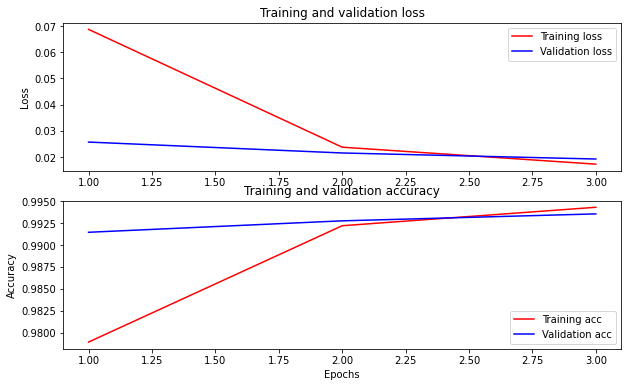

In [17]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [26]:
loss, accuracy = model.evaluate(x_val, y_val)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

94/94 [==============================] - 8s 87ms/step - loss: 0.0193 - sparse_categorical_accuracy: 0.9936
Loss: 0.01925029046833515
Accuracy: 0.9935520887374878


In [27]:
def predict_from_text(text, model):
    n_tokens = len(tokenizer.tokenize(text, padded_token=False)['input_ids'])
    tokens = tokenizer.bert_pack_inputs([text])
    x_test = tokens
    pred_test = model.predict(x_test) if hasattr(model, 'predict') else model(x_test)
    # ignore predictions of padding tokens
    pred_tags = np.argmax(pred_test, 2)[0][:n_tokens]

    tags = label_tokenizer.decode(pred_tags)
    res = []
    words = {
        'word': '',
        'tag': None
    }
    for idx, tag in enumerate(tags):
        if(tag != 'O' and tag != '[PAD]'):
            pre, suf = tag.split('-')
            words['tag'] = suf
            token = x_test[0][0][idx]
            token = token.numpy()
            word = tokenizer.decode(token)
            # word = preprocessor.decode(word)
            words['word'] = words['word'] + word if words['word'] else word
        else:
            if(words['tag']):
                res.append(words)
            words = {
                'word': '',
                'tag': None
            }
    return pd.DataFrame(res)


In [28]:
test_inputs = '李华住在朝阳区香河园街道西坝河北里社区，在5月4号去过天安门广场，5号下午去了太阳宫凯德茂商场。'

In [29]:
print(predict_from_text(test_inputs, model))


              word  tag
0               李华  PER
1  朝阳区香河园街道西坝河北里社区  LOC
2            天安门广场  LOC
3         太阳宫凯德茂商场  LOC


In [22]:
model.save(saved_model, include_optimizer=False)


2022-06-14 23:29:30.756939: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tr_ner_albert/assets


INFO:tensorflow:Assets written to: tr_ner_albert/assets


In [30]:
reload_model = tf.saved_model.load(saved_model)


In [31]:
print(predict_from_text(test_inputs, reload_model))


2022-06-14 23:30:40.868632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              word  tag
0               李华  PER
1  朝阳区香河园街道西坝河北里社区  LOC
2            天安门广场  LOC
3         太阳宫凯德茂商场  LOC


In [32]:
text = '无症状感染者28：现住朝阳区慧苑商住公寓，曾到访天堂超市酒吧(工体西路6号)，6月13日诊断为无症状感染者'

print(predict_from_text(text, model))


        word  tag
0  朝阳区慧苑商住公寓  LOC
1     天堂超市酒吧  LOC
2     工体西路6号  LOC
